**About the Analysis:**

From SDSS web page,

"The Sloan Digital Sky Survey has created the most detailed three-dimensional maps of the Universe ever made, with deep multi-color images of one third of the sky, and spectra for more than three million astronomical objects."

**About the data:**

From the Overview section,

"The data consists of 10,000 observations of space taken by the SDSS. Every observation is described by 17 feature columns and 1 class column which identifies it to be either a **star, galaxy or quasar**."

The Analysis below, tries to study the different features of star, galaxy and quasar and uses Support Vector Machine(SVM) algorithm to predict the three classes *STAR, GALAXY OR QUASAR.* 

I know about Star and Galaxy but had no idea about quasar, so in order to understand what exactly we are classifying here, it's better to know a little bit about them as well. I will start with quasar first(taken from wikipedia).

Quasar- Also known as quasi-stellar object, it is an extremely luminous active galactic nucleus (AGN). The power radiated by quasars is enormous. The most powerful quasars have luminosities exceeding 1041 watts, thousands of times greater than an ordinary large galaxy such as the Milky Way.

Galaxy- A galaxy is a gravitationally bound system of stars, stellar remnants, interstellar gas, dust, and dark matter. 
Galaxies are categorized according to their visual morphology as elliptical, spiral, or irregular. Many galaxies are thought to have supermassive black holes at their active centers.

Star- A star is type of astronomical object consisting of a luminous spheroid of plasma held together by its own gravity. The nearest star to Earth is the Sun. 

**Loading the Libraries & the Data:**

As my knowledge on astronomical objects is infinitesimal, it is better to import and check the data for further details. But, first I will load the libraries.

In [ ]:
## Importing packages

library(tidyverse) 
library(cowplot)
library(MASS)
library(car)
library(e1071)
library(caret)
library(caTools)
library(kernlab)
library(IRdisplay)
library(plotly)
options(warn = -1)
#options(scipen= 999)

In [ ]:
#Importing the data
sky <- read_csv("../input/Skyserver_SQL2_27_2018 6_51_39 PM.csv")

In [ ]:
#Checking the data and types
glimpse(sky)

**Brief Details of each observation:**

ra (right ascension) and dec (declination) are the coordinates on the sky that correspond to longitude and latitude on Earth. RA measures east and west on the celestial sphere and is like longitude on the Earth. Dec measures north and south on the celestial sphere and is like latitude on the Earth.

* objid = Object Identifier
* ra = J2000 Right Ascension (r-band)-
* dec = J2000 Declination (r-band)

Knowing that the color of a star is related to the wavelength of light it gives off, lets you understand the meaning of the SDSS's color filters. Each filter is designed to let in light around a specific wavelength. The filters work by blocking out light at all wavelengths except those around the wavelength they are designed to see. 

* u (ultraviolet)= better of DeV/Exp magnitude fit
* g (green) = better of DeV/Exp magnitude fit
* r (red) = better of DeV/Exp magnitude fit
* i (Near infrared) = better of DeV/Exp magnitude fit
* z (Infrared) = better of DeV/Exp magnitude fit

* run = Run Number
* rereun = Rerun Number
* camcol = Camera column
* field = Field number
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)
* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiber ID

In [ ]:
#Checking for NA values, and there are none.
colSums(is.na(sky))

In [ ]:
#Checking for unique values in each column
sky%>%summarise_all(funs(n_distinct))

Most of the observations belong to class galaxy and then followed by star. The observations pertaining to quasar is very less.

In [ ]:
options(repr.plot.width=10, repr.plot.height=6)
p1 <- ggplotly(ggplot(sky, aes(class, fill = class)) + geom_bar() + theme_bw())

htmlwidgets::saveWidget(p1, "p1.html")
display_html('<iframe src="p1.html" width=100% height=450></iframe>')

Next few plots shows the density distribution of each column. 

In [ ]:
theme1<- theme_bw()+theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), 
                   legend.position="top")

theme2<- theme_bw()+theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), 
                   legend.position="none")

plot_grid(ggplot(sky, aes(ra, fill = class)) + geom_density(alpha = 0.7)+theme1, 
          ggplot(sky, aes(dec, fill = class)) + geom_density(alpha = 0.7)+theme1,
          ggplot(sky, aes(u, fill = class)) + geom_density(alpha = 0.7)+theme1,
          ggplot(sky, aes(g, fill = class)) + geom_density(alpha = 0.7)+theme2,
          ggplot(sky, aes(r, fill = class)) + geom_density(alpha = 0.7)+theme2,
          ggplot(sky, aes(i, fill = class)) + geom_density(alpha = 0.7)+theme2,
          align = "h")

In [ ]:
plot_grid(ggplot(sky, aes(z, fill = class)) + geom_density(alpha = 0.7)+theme1, 
          ggplot(sky, aes(run, fill = class)) + geom_density(alpha = 0.7)+theme1,
          ggplot(sky, aes(rerun, fill = class)) + geom_density(alpha = 0.7)+theme1,
          ggplot(sky, aes(camcol, fill = class)) + geom_density(alpha = 0.7)+theme2,
          ggplot(sky, aes(field, fill = class)) + geom_density(alpha = 0.7)+theme2,
          ggplot(sky, aes(specobjid, fill = class)) + geom_density(alpha = 0.7)+theme2,
          align = "h")   

In [ ]:
plot_grid(ggplot(sky, aes(redshift, fill = class)) + geom_density(alpha = 0.6)+theme1, 
          ggplot(sky, aes(plate, fill = class)) + geom_density(alpha = 0.6)+theme1,
          ggplot(sky, aes(mjd, fill = class)) + geom_density(alpha = 0.6)+theme2,
          ggplot(sky, aes(fiberid, fill = class)) + geom_density(alpha = 0.6)+theme2,
          align = "h")  

In [ ]:
p4 <- plot_ly(sky, x = sky$ra, y = sky$dec, z = sky$redshift, color = ~sky$class)  %>%
  add_markers() %>%
  layout(scene = list(xaxis = list(title = 'x-axis'),
                     yaxis = list(title = 'y-axis'),
                     zaxis = list(title = 'z-axis')))

htmlwidgets::saveWidget(p4, "p4.html")
display_html('<iframe src="p4.html" width=100% height=450></iframe>')

In [ ]:
options(repr.plot.width=12, repr.plot.height=4)
ugriz <- sky %>% gather(4:8 ,key = "spectrum", value = "Total")%>%
group_by(ra,dec,spectrum,class) %>% 
summarise(spec = sum(Total)) 

ggplot(ugriz, aes(x= spec, color = spectrum)) +
geom_density()+
facet_grid(~class)+
theme_bw()


**MODEL BUILDING:**

I will try to apply Support Vector Machines(SVM) algorithm to classify the three classes here. Like linear regression and logistic regression, SVMs are also linear models. The attributes must be in numeric form. SVMs uses the concept of Hyperplane, Maximal Margin Classifier and Soft Margin Classifier to separate the linear boundaries. However, there are datsets that are not always linearly separable, in these cases kernel trick is used to transform the attribute space to feature space to make the data linearly separable. 

I am including very brief refresher of Hyperplane, Maximal Margin Classifier and Soft Margin Classifer etc. below before building the model(this will help me remember the concepts, every time I go through this kernel).

**Hyperplane:**

Hyperplane is basically a boundary that classifies one class from another in a dataset. It can be a line or any n-dimensional plane. An example of a 3 dimensional hyperplane is given below. All the points above the plane(the green one) belong to one class and the points below the plane are from another class.

![Imgur.png](https://i.imgur.com/KE8RtyV.png)

**Maximal Margin Classifier:**

While deciding the most optimal hyperplane, one must choose the hyperplane that maintains the largest distance from the nearest points of all classes. This line(or hyperplane) is known as Maximal Margin Classifier. This type of classifier, correctly classifies all the data points, however, it is very sensitive to training data. An example is shown below. Here, the most optimal separator will be line B, as it has maximum distance from the nearest data points of both the classes.

![Imgur.png](https://i.imgur.com/O71iYwf.png)

**Soft Margin Classifier:**

The Soft Margin Classifier, while classifying data points, deliberately missclassifies few data points. This is how, it tries to make the model more robust. It is also called as Support Vector Classifier, because, the points that are closest to the separator are used to decide the best hyperplane here, and these closest data points are known as support vectors. An example is shown below,

![Imgur.png](https://i.imgur.com/QNGQfvq.png)

**DATA PREPARATION FOR MODELLING:**

* Removing the non-numeric variables.
* Converting the target 'class' to factor.
* Splitting the data to train and test.

In [ ]:
sky <- sky[,-c(1,10,13,18)]
sky$class <- factor(sky$class)

In [ ]:
# splitting the data between train and test
set.seed(100)

indices = sample.split(sky$class, SplitRatio = 0.7)

train = sky[indices,]

test = sky[!(indices),]


In [ ]:
head(test)

**A- THE LINEAR KERNEL:**

This is same as the Support Vector Classifier or the hyperplane, without any transformation at all.
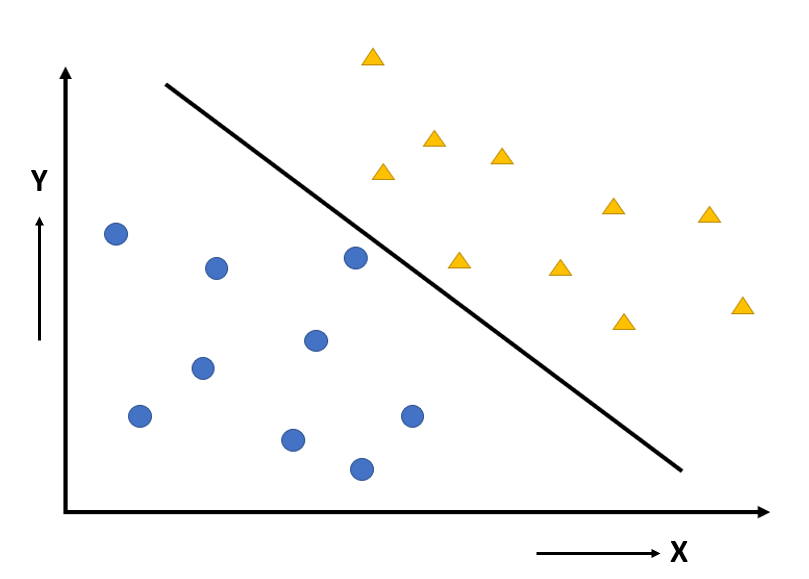



The Linear Kernel has given an accuracy of 0.98 in our test data(see below).
 The sensitivity and specificity of each class is given as,
 
                            Class: GALAXY    QSO      STAR
                 
    Sensitivity                 0.9733    0.95686      0.9928

    Specificity                 0.9867    0.99745      0.9812

In [ ]:
#Using Linear Kernel
Model_linear <- ksvm(class~ ., data = train, scale = FALSE, kernel = "vanilladot")
Eval_linear<- predict(Model_linear, test[,-11])

  #confusion matrix - Linear Kernel
  confusionMatrix(Eval_linear,test$class)

**B- THE POLYNOMIAL KERNEL:**

The polynomial kernel can produce polynomial shaped nonlinear boundaries. The polynomial kernel considers the given features of input samples to determine their similarity and the combinations of these features as well. 

![Imgur.png](https://i.imgur.com/BZ5ywu9.png)

In [ ]:
#Using polynomial Kernel
Model_poly <- ksvm(class~ ., data = train, scale = FALSE, kernel = "polydot")
Eval_poly <- predict(Model_poly, test[,-11])

  #confusion matrix - Polynomial Kernel
  confusionMatrix(Eval_poly,test$class)

**C- THE RBF KERNEL**

The radial basis function or the RBF kernel is the most complex kernel function. It is capable of transforming highly nonlinear feature spaces to linear ones. The RBF kernel can produce highly nonlinear, ellipsoid boundaries as well.

![Imgur.png](https://i.imgur.com/L9URarn.png)


In [ ]:
#Using RBF Kernel
Model_RBF <- ksvm(class~ ., data = train, scale = FALSE, kernel = "rbfdot")
Eval_RBF <- predict(Model_RBF, test[,-11])

  #confusion matrix - RBF Kernel
  confusionMatrix(Eval_RBF,test$class)

**Hyperparameter tuning and Cross Validation:**

We will use the train function from 'CARET Package' to perform Cross Validation. 

traincontrol function Controls the computational nuances of the train function.

* Method =  CV means  Cross Validation.
* Number = 5 implies Number of folds in CV.

* In nonlinear kernels, we use the parameter sigma to control the amount of nonlinearity in the model. 
* The higher the value of sigma, the more is the nonlinearity introduced. 
* Apart from sigma, we also have the hyperparameter C or the cost function. 
* The cost or regularisation parameter 'C' controls the trade-off between maximising the margin and minimising the training error.
* As 'C' increases, the number of misclassifications is lower.
* Sigma can be any real number and C, needs to be a positive number.

In [ ]:
trainControl <- trainControl(method="cv", number=5)
metric <- "Accuracy"
set.seed(100)
grid <- expand.grid(.sigma=c(0.01,0.02,0.03,0.04), .C=c(5,6,7,8) )

fit.svm <- train(class~., data=train, method="svmRadial", metric=metric, 
                 tuneGrid=grid, trControl=trainControl)

print(fit.svm)


# Plotting "fit.svm" results
plot(fit.svm)


In [ ]:
#Evaluating on the test data

evaluate_kernel_test<- predict(fit.svm, test[, -11])
confusionMatrix(evaluate_kernel_test, test$class)

In RBF Kernel model, first we got an accuracy of 95.83, after hyperparameter tuning with sigma = 0.03 and C = 8, we got an overall accuracy of 97.47, with the following classification accuracies,

                     Class:      GALAXY   QSO          STAR
    Sensitivity                 0.9673    0.93725      0.9912
    Specificity                 0.9833    0.99745      0.9749

The Linear Kernel itself has done a pretty decent job of classifying the Galaxy, QSO and STAR, with an accuracy of 0.98, with the following classifications.

    Prediction GALAXY  QSO STAR
        GALAXY   1459   11    9
        QSO         7  244    0
        STAR       33    0   1237




References:

[https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey/home](http://)

[https://en.wikipedia.org/wiki/Galaxy](http://)

[https://en.wikipedia.org/wiki/Quasar](http://)

[https://www.celestron.com/blogs/knowledgebase/what-are-ra-and-dec](http://)

[http://skyserver.sdss.org/dr2/en/proj/advanced/color/sdssfilters.asp](http://)

[http://beta.cambridgespark.com/courses/jpm/05-module.html](http://)

Thank You for visiting. 